## Physics Informed Neural Networks to Approximate Solution of High-Dimensional PDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader

# Adapt this import to your specific directory tree.
from Common import NeuralNet, MultiVariatePoly
import time
torch.manual_seed(128)

Consider the one-dimensional parametric heat equation:

$$
u_t(t, x, \mu) = u_{xx}(t, x, \mu), \quad t\in[0,T], ~x\in [-1,1], ~\mu\in [-1,1]^d
$$

where the parametric nature of the PDE stems from the initial condition

$$
u(0, x, \mu) = u_0(x, \mu) = \sum_{m}^d u_0^m(x, \mu_m) = - \frac{1}{d}\sum_{m=1}^d \mu_m\sin(\pi m x )/m^{0.5}
$$

with

$$
u_0^m(x, \mu_m) = - \mu_m\sin(\pi m x )/m^{0.5}
$$

Similarly to the previous tutorials, consider zero Dirichlet BC:
$$
u_b(t, -1, \mu)=u_b(t,1, \mu)=0,
$$

We want to obtain an approximate solution of the heat equation $u : [0,T]\times[-1,1]\times[-1,1]^d  \mapsto R$ with physics informed neural networks (PINNs).

To do so, we consider the following ansatz for the solution of the PDE:

$$
\bar{u}_\theta(t,x,\mu) =  \frac{1}{d}\sum_{m=1}^d u_0^m(x, \mu_m)(1 - t u^m_{\theta}(t,x,\mu)) \approx u(t,x, \mu)
$$
with $u_\theta(t,x,\mu):\mathbb{R}^{2+d}\mapsto \mathbb{R}^{d}$, $u_\theta(t,x,\mu) =(u^1_\theta(t,x,\mu), ..., u^d_\theta(t,x,\mu))$ being a feedforward dense neural network with tunable parameters $\theta$.

This ansatz is a natural choice for this type of problem, given the nature of the initial condition, which is the superposition of different functions $u_0^m(x, \mu_m)$ and the linearity of the PDE. As a consequence, the PDE solution is the superposition of the solutions of the PDE with initial conditions given by $u_0^m(x, \mu_m)$.

Define the following residuals:

- Interior residual given by,
   
\begin{equation}
         r_{int,\theta}(t, x, \mu):=  \bar{u}_\theta(t, x, \mu) - \bar{u}_{\theta, xx}(t, x, \mu), \quad \forall ~t \in [0,T],~ x \in [-1,1], ~\mu \in [-1,1]^d.
\end{equation}
        
- Spatial boundary residual given by,
   
\begin{equation}
    r_{sb,\theta}(t,-1,\mu):= \bar{u}_{\theta}(t,-1, \mu)- u_b(t,-1, \mu), \quad r_{sb,\theta}(t,1, \mu):= \bar{u}_{\theta}(t,1, \mu)- u_b(t,1, \mu), \quad \forall t \in (0,T], ~\mu \in [-1,1]^d .
\end{equation}

        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x,\mu):= \bar{u}_{\theta}(x,0,\mu) - u_0(x,\mu), \quad \forall x \in [-1,1], ~\mu \in [-1,1]^d.$$

Observe that given the definition of $\bar{u}$, the boundaries residuals are identically zero.


Therefore, we only need to compute the interior loss given the training data

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t, \mu)_n \in [0,T]\times[-1,1]\times[-1,1]^d,
$$

$$
L_{int}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta}^2(y_n)
$$

and solve the minimization problem

$$
\theta^\ast = argmin_{\theta} \Big(L_{int}(\theta)\Big)
$$




In [2]:
class HardBCPinns(torch.nn.Module):

    def __init__(self, ic, u_tilde):
        super().__init__()
        self.ic = ic
        self.u_tilde = u_tilde

    def forward(self, x):
        time_coord = x[:, 0].reshape(-1, )

        u0 = self.ic(x[:, 1:])
        u_tilde = self.u_tilde(x)
        sol = torch.sum((1 - time_coord[:, None] * u_tilde) * u0, -1)

        return sol.reshape(-1, 1)

class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 0.1],  # Time dimension
                                            [-1, 1]])  # Space dimension

        self.p = 5
        self.parameters_extrema = torch.ones((self.p, 2))
        self.parameters_extrema[:, 0] = -1

        self.domain_extrema = torch.cat(
            (self.domain_extrema, self.parameters_extrema), 0)

        # Number of space dimensions
        self.space_dimensions = 1

        # FF Dense NN to approximate the solution of the underlying heat equation
        self.nn = NeuralNet(input_dimension=2 + self.p,
                            output_dimension=self.p,
                            n_hidden_layers=4,
                            neurons=20,
                            regularization_param=0.,
                            regularization_exp=2.,
                            retrain_seed=42)

        self.approximate_solution = HardBCPinns(
            self.get_initial_condition_modes, self.nn)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(
            dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, inputs):
        t0 = torch.full((inputs.shape[0], 1), self.domain_extrema[0, 0])
        inputs = torch.cat((t0, inputs), 1)
        return self.exact_solution(inputs)

    def get_initial_condition_modes(self, inputs):
        x = inputs[:, 0]
        mu = inputs[:, 1:]
        u = torch.zeros((inputs.shape[0], self.p))
        for i in range(1, self.p + 1):
            u[:, i-1] = -mu[:, i - 1]/self.p * torch.sin(np.pi * x * i) / i ** 0.5
        return u

    # Exact solution for the heat equation ut = u_xx with the IC above
    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]
        mu = inputs[:, 2:]
        u = 0
        for i in range(1, self.p + 1):
            u = u - torch.exp(-(np.pi * i) ** 2 * t) * mu[:, i - 1]/self.p * torch.sin(np.pi * x * i) / i ** 0.5

        return u

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1:]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()  # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)

        return u_pred_sb

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]

        residual = grad_u_t - grad_u_xx
        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])

        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_u = loss_sb + loss_tb

        # Loss is given only by the interior one since the boundary and initial conditions are automatically satisfied.
        loss = torch.log10(loss_int)
        if verbose:
           print(
               "Total loss: ", round(loss.item(), 4),
                "| PDE Loss: ", round(torch.log10(loss_int).item(), 4), "| Function Loss: ", round(torch.log10(loss_u).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        t = torch.linspace(0, 1, 50)
        x = torch.linspace(0, 1, 50)
        input_tx = torch.cartesian_prod(t, x)

        for i in range(5):
            mu = torch.rand((1, self.p))
            mu = mu.repeat(input_tx.shape[0], 1)

            inputs = torch.cat((input_tx, mu), -1)
            inputs = self.convert(inputs)

            output = self.approximate_solution(inputs).reshape(50, 50)
            exact_output = self.exact_solution(inputs).reshape(50, 50)

            fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
            im1 = axs[0].contourf(x, t, exact_output.detach(), cmap="jet", levels=200)
            axs[0].set_xlabel("x")
            axs[0].set_ylabel("t")
            plt.colorbar(im1, ax=axs[0])
            axs[0].grid(True, which="both", ls=":")
            im2 = axs[1].contourf(x, t, output.detach(), cmap="jet", levels=200)
            axs[1].set_xlabel("x")
            axs[1].set_ylabel("t")
            plt.colorbar(im2, ax=axs[1])
            axs[1].grid(True, which="both", ls=":")
            axs[0].set_title("Exact Solution")
            axs[1].set_title("Approximate Solution")

            plt.show()

            err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
            print("L2 Relative Error Norm: ", err.item(), "%")


In [3]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 8192
n_sb = 4
n_tb = 4

pinn = Pinns(n_int, n_sb, n_tb)

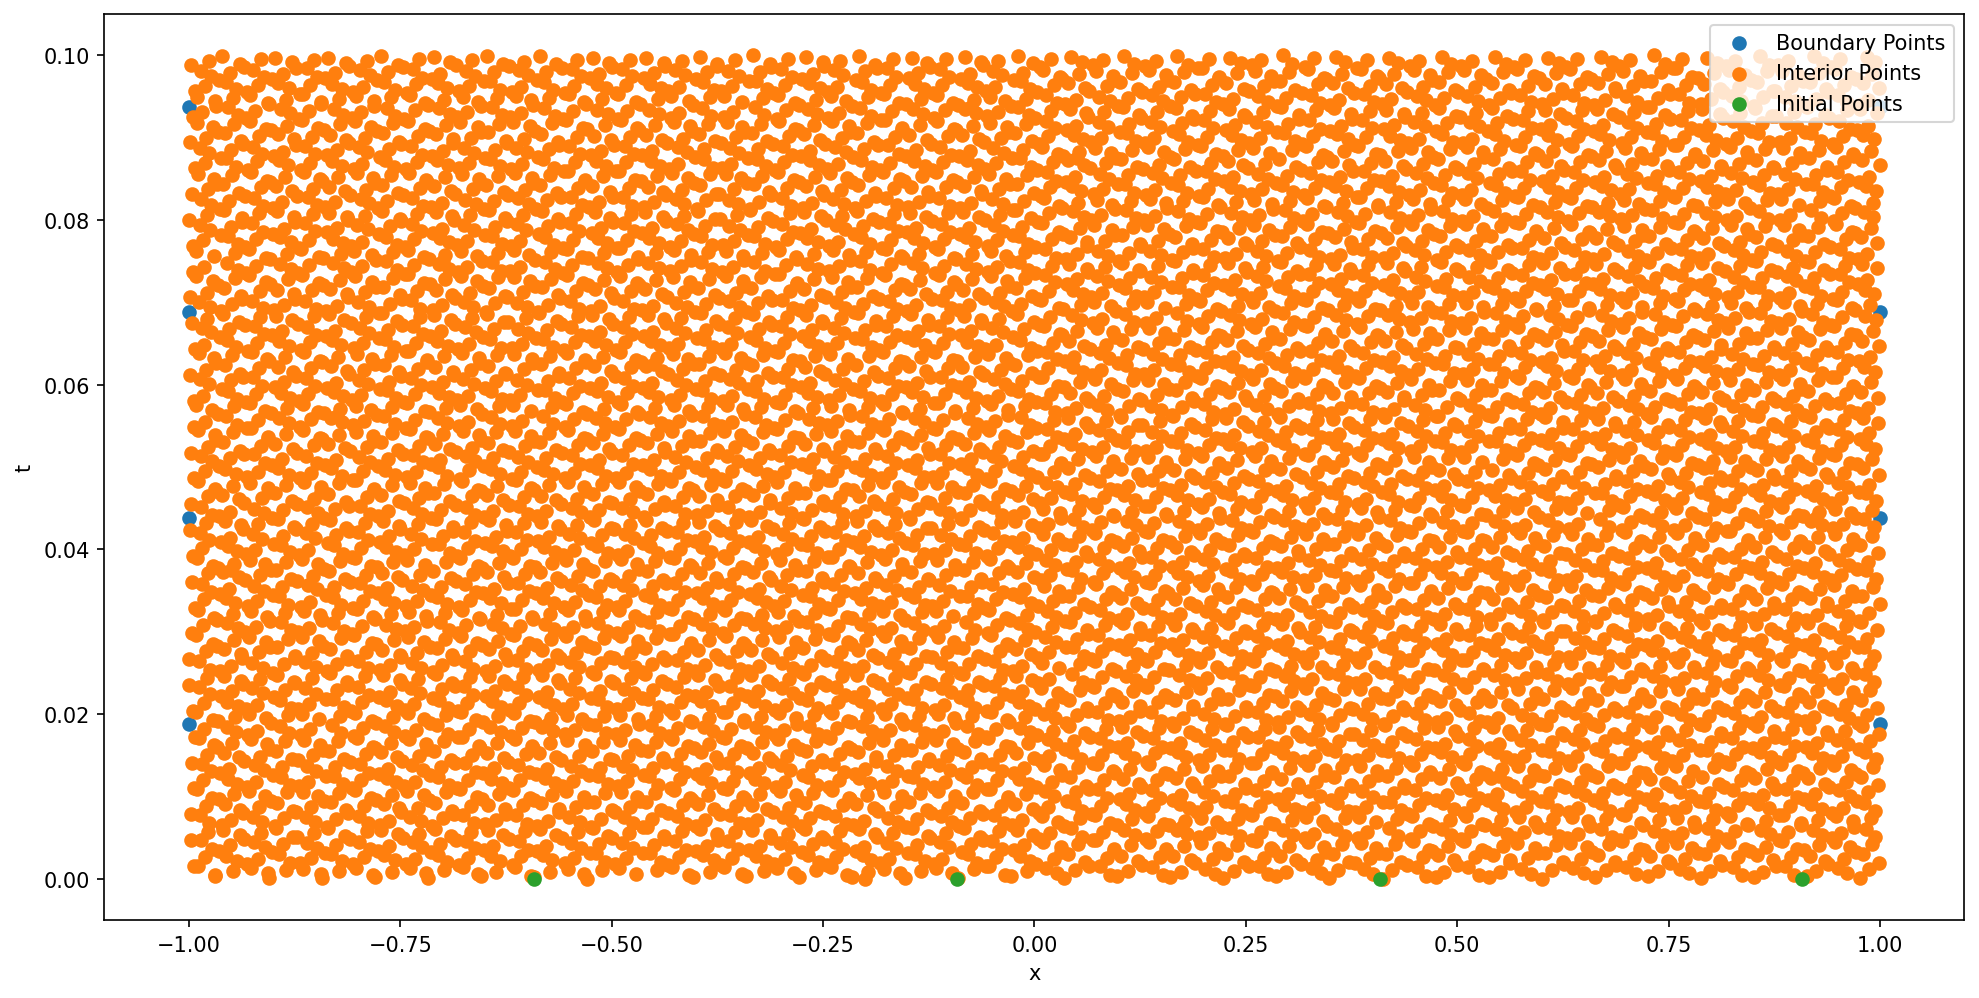

In [4]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [5]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=10000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.005))

################################  0  ################################
Total loss:  2.1666 | PDE Loss:  2.1666 | Function Loss:  -14.9748
Total loss:  2.162 | PDE Loss:  2.162 | Function Loss:  -14.9809
Total loss:  2.122 | PDE Loss:  2.122 | Function Loss:  -15.0347
Total loss:  2.0512 | PDE Loss:  2.0512 | Function Loss:  -15.1177
Total loss:  1.929 | PDE Loss:  1.929 | Function Loss:  -15.238
Total loss:  1.6435 | PDE Loss:  1.6435 | Function Loss:  -15.5016
Total loss:  1.5395 | PDE Loss:  1.5395 | Function Loss:  -15.535
Total loss:  1.5118 | PDE Loss:  1.5118 | Function Loss:  -15.5227
Total loss:  1.5054 | PDE Loss:  1.5054 | Function Loss:  -15.518
Total loss:  1.4931 | PDE Loss:  1.4931 | Function Loss:  -15.5122
Total loss:  1.4887 | PDE Loss:  1.4887 | Function Loss:  -15.5038
Total loss:  1.4868 | PDE Loss:  1.4868 | Function Loss:  -15.5017
Total loss:  1.4858 | PDE Loss:  1.4858 | Function Loss:  -15.5005
Total loss:  1.4854 | PDE Loss:  1.4854 | Function Loss:  -15.5033
T

Total loss:  0.3811 | PDE Loss:  0.3811 | Function Loss:  -15.9221
Total loss:  0.3695 | PDE Loss:  0.3695 | Function Loss:  -15.9287
Total loss:  0.359 | PDE Loss:  0.359 | Function Loss:  -15.9332
Total loss:  0.3505 | PDE Loss:  0.3505 | Function Loss:  -15.9358
Total loss:  0.3438 | PDE Loss:  0.3438 | Function Loss:  -15.9424
Total loss:  0.3374 | PDE Loss:  0.3374 | Function Loss:  -15.9375
Total loss:  0.3321 | PDE Loss:  0.3321 | Function Loss:  -15.9339
Total loss:  0.3255 | PDE Loss:  0.3255 | Function Loss:  -15.9313
Total loss:  0.317 | PDE Loss:  0.317 | Function Loss:  -15.9248
Total loss:  0.3075 | PDE Loss:  0.3075 | Function Loss:  -15.9204
Total loss:  0.2923 | PDE Loss:  0.2923 | Function Loss:  -15.9175
Total loss:  0.2661 | PDE Loss:  0.2661 | Function Loss:  -15.9118
Total loss:  0.2517 | PDE Loss:  0.2517 | Function Loss:  -15.9147
Total loss:  0.2419 | PDE Loss:  0.2419 | Function Loss:  -15.9129
Total loss:  0.2176 | PDE Loss:  0.2176 | Function Loss:  -15.9284

Total loss:  -0.692 | PDE Loss:  -0.692 | Function Loss:  -15.9489
Total loss:  -0.6974 | PDE Loss:  -0.6974 | Function Loss:  -15.9495
Total loss:  -0.7031 | PDE Loss:  -0.7031 | Function Loss:  -15.9498
Total loss:  -0.7088 | PDE Loss:  -0.7088 | Function Loss:  -15.9494
Total loss:  -0.7156 | PDE Loss:  -0.7156 | Function Loss:  -15.9495
Total loss:  -0.7223 | PDE Loss:  -0.7223 | Function Loss:  -15.9487
Total loss:  -0.7255 | PDE Loss:  -0.7255 | Function Loss:  -15.949
Total loss:  -0.7309 | PDE Loss:  -0.7309 | Function Loss:  -15.9483
Total loss:  -0.7341 | PDE Loss:  -0.7341 | Function Loss:  -15.9479
Total loss:  -0.7371 | PDE Loss:  -0.7371 | Function Loss:  -15.9478
Total loss:  -0.7419 | PDE Loss:  -0.7419 | Function Loss:  -15.9477
Total loss:  -0.7473 | PDE Loss:  -0.7473 | Function Loss:  -15.948
Total loss:  -0.752 | PDE Loss:  -0.752 | Function Loss:  -15.9479
Total loss:  -0.7562 | PDE Loss:  -0.7562 | Function Loss:  -15.9484
Total loss:  -0.7599 | PDE Loss:  -0.759

Total loss:  -1.174 | PDE Loss:  -1.174 | Function Loss:  -15.9465
Total loss:  -1.18 | PDE Loss:  -1.18 | Function Loss:  -15.9461
Total loss:  -1.1841 | PDE Loss:  -1.1841 | Function Loss:  -15.9462
Total loss:  -1.1847 | PDE Loss:  -1.1847 | Function Loss:  -15.9452
Total loss:  -1.1864 | PDE Loss:  -1.1864 | Function Loss:  -15.9457
Total loss:  -1.1889 | PDE Loss:  -1.1889 | Function Loss:  -15.9455
Total loss:  -1.1917 | PDE Loss:  -1.1917 | Function Loss:  -15.945
Total loss:  -1.1942 | PDE Loss:  -1.1942 | Function Loss:  -15.9448
Total loss:  -1.197 | PDE Loss:  -1.197 | Function Loss:  -15.9444
Total loss:  -1.198 | PDE Loss:  -1.198 | Function Loss:  -15.9448
Total loss:  -1.2007 | PDE Loss:  -1.2007 | Function Loss:  -15.9448
Total loss:  -1.2021 | PDE Loss:  -1.2021 | Function Loss:  -15.9448
Total loss:  -1.2035 | PDE Loss:  -1.2035 | Function Loss:  -15.9451
Total loss:  -1.2048 | PDE Loss:  -1.2048 | Function Loss:  -15.9452
Total loss:  -1.2067 | PDE Loss:  -1.2067 | F

Total loss:  -1.5472 | PDE Loss:  -1.5472 | Function Loss:  -15.9441
Total loss:  -1.5496 | PDE Loss:  -1.5496 | Function Loss:  -15.9441
Total loss:  -1.5516 | PDE Loss:  -1.5516 | Function Loss:  -15.9439
Total loss:  -1.5532 | PDE Loss:  -1.5532 | Function Loss:  -15.9437
Total loss:  -1.5554 | PDE Loss:  -1.5554 | Function Loss:  -15.9435
Total loss:  -1.5575 | PDE Loss:  -1.5575 | Function Loss:  -15.9433
Total loss:  -1.5592 | PDE Loss:  -1.5592 | Function Loss:  -15.9432
Total loss:  -1.5613 | PDE Loss:  -1.5613 | Function Loss:  -15.9429
Total loss:  -1.5642 | PDE Loss:  -1.5642 | Function Loss:  -15.9429
Total loss:  -1.5689 | PDE Loss:  -1.5689 | Function Loss:  -15.943
Total loss:  -1.5722 | PDE Loss:  -1.5722 | Function Loss:  -15.9432
Total loss:  -1.5743 | PDE Loss:  -1.5743 | Function Loss:  -15.9433
Total loss:  -1.5761 | PDE Loss:  -1.5761 | Function Loss:  -15.9437
Total loss:  -1.5773 | PDE Loss:  -1.5773 | Function Loss:  -15.9437
Total loss:  -1.5793 | PDE Loss:  -

Total loss:  -1.7745 | PDE Loss:  -1.7745 | Function Loss:  -15.9428
Total loss:  -1.7751 | PDE Loss:  -1.7751 | Function Loss:  -15.9429
Total loss:  -1.7759 | PDE Loss:  -1.7759 | Function Loss:  -15.9429
Total loss:  -1.7764 | PDE Loss:  -1.7764 | Function Loss:  -15.9428
Total loss:  -1.7773 | PDE Loss:  -1.7773 | Function Loss:  -15.9429
Total loss:  -1.7781 | PDE Loss:  -1.7781 | Function Loss:  -15.943
Total loss:  -1.7787 | PDE Loss:  -1.7787 | Function Loss:  -15.9429
Total loss:  -1.7792 | PDE Loss:  -1.7792 | Function Loss:  -15.9429
Total loss:  -1.7796 | PDE Loss:  -1.7796 | Function Loss:  -15.9429
Total loss:  -1.78 | PDE Loss:  -1.78 | Function Loss:  -15.9428
Total loss:  -1.7803 | PDE Loss:  -1.7803 | Function Loss:  -15.9428
Total loss:  -1.7807 | PDE Loss:  -1.7807 | Function Loss:  -15.9427
Total loss:  -1.7811 | PDE Loss:  -1.7811 | Function Loss:  -15.9427
Total loss:  -1.7816 | PDE Loss:  -1.7816 | Function Loss:  -15.9427
Total loss:  -1.782 | PDE Loss:  -1.782

Total loss:  -1.8763 | PDE Loss:  -1.8763 | Function Loss:  -15.9412
Total loss:  -1.8768 | PDE Loss:  -1.8768 | Function Loss:  -15.9411
Total loss:  -1.8773 | PDE Loss:  -1.8773 | Function Loss:  -15.9411
Total loss:  -1.8779 | PDE Loss:  -1.8779 | Function Loss:  -15.9411
Total loss:  -1.879 | PDE Loss:  -1.879 | Function Loss:  -15.941
Total loss:  -1.8809 | PDE Loss:  -1.8809 | Function Loss:  -15.941
Total loss:  -1.883 | PDE Loss:  -1.883 | Function Loss:  -15.941
Total loss:  -1.8846 | PDE Loss:  -1.8846 | Function Loss:  -15.9411
Total loss:  -1.8852 | PDE Loss:  -1.8852 | Function Loss:  -15.941
Total loss:  -1.8865 | PDE Loss:  -1.8865 | Function Loss:  -15.9414
Total loss:  -1.8873 | PDE Loss:  -1.8873 | Function Loss:  -15.9414
Total loss:  -1.8878 | PDE Loss:  -1.8878 | Function Loss:  -15.9414
Total loss:  -1.8885 | PDE Loss:  -1.8885 | Function Loss:  -15.9413
Total loss:  -1.8891 | PDE Loss:  -1.8891 | Function Loss:  -15.9413
Total loss:  -1.8896 | PDE Loss:  -1.8896 

Total loss:  -1.9313 | PDE Loss:  -1.9313 | Function Loss:  -15.942
Total loss:  -1.9318 | PDE Loss:  -1.9318 | Function Loss:  -15.9419
Total loss:  -1.9323 | PDE Loss:  -1.9323 | Function Loss:  -15.9419
Total loss:  -1.9327 | PDE Loss:  -1.9327 | Function Loss:  -15.9418
Total loss:  -1.9329 | PDE Loss:  -1.9329 | Function Loss:  -15.9418
Total loss:  -1.9332 | PDE Loss:  -1.9332 | Function Loss:  -15.9418
Total loss:  -1.9336 | PDE Loss:  -1.9336 | Function Loss:  -15.9418
Total loss:  -1.9338 | PDE Loss:  -1.9338 | Function Loss:  -15.9418
Total loss:  -1.9341 | PDE Loss:  -1.9341 | Function Loss:  -15.9418
Total loss:  -1.9345 | PDE Loss:  -1.9345 | Function Loss:  -15.9418
Total loss:  -1.935 | PDE Loss:  -1.935 | Function Loss:  -15.9418
Total loss:  -1.9353 | PDE Loss:  -1.9353 | Function Loss:  -15.9417
Total loss:  -1.936 | PDE Loss:  -1.936 | Function Loss:  -15.9417
Total loss:  -1.9367 | PDE Loss:  -1.9367 | Function Loss:  -15.9417
Total loss:  -1.9377 | PDE Loss:  -1.93

Total loss:  -2.1671 | PDE Loss:  -2.1671 | Function Loss:  -15.9414
Total loss:  -2.1721 | PDE Loss:  -2.1721 | Function Loss:  -15.9415
Total loss:  -2.1768 | PDE Loss:  -2.1768 | Function Loss:  -15.9414
Total loss:  -2.1803 | PDE Loss:  -2.1803 | Function Loss:  -15.9414
Total loss:  -2.1843 | PDE Loss:  -2.1843 | Function Loss:  -15.9418
Total loss:  -2.1867 | PDE Loss:  -2.1867 | Function Loss:  -15.9418
Total loss:  -2.1889 | PDE Loss:  -2.1889 | Function Loss:  -15.9418
Total loss:  -2.1899 | PDE Loss:  -2.1899 | Function Loss:  -15.9418
Total loss:  -2.1904 | PDE Loss:  -2.1904 | Function Loss:  -15.9418
Total loss:  -2.1911 | PDE Loss:  -2.1911 | Function Loss:  -15.9418
Total loss:  -2.1918 | PDE Loss:  -2.1918 | Function Loss:  -15.9418
Total loss:  -2.1924 | PDE Loss:  -2.1924 | Function Loss:  -15.9417
Total loss:  -2.1931 | PDE Loss:  -2.1931 | Function Loss:  -15.9417
Total loss:  -2.1937 | PDE Loss:  -2.1937 | Function Loss:  -15.9417
Total loss:  -2.1944 | PDE Loss:  

Total loss:  -2.2507 | PDE Loss:  -2.2507 | Function Loss:  -15.941
Total loss:  -2.2511 | PDE Loss:  -2.2511 | Function Loss:  -15.941
Total loss:  -2.2516 | PDE Loss:  -2.2516 | Function Loss:  -15.941
Total loss:  -2.2522 | PDE Loss:  -2.2522 | Function Loss:  -15.941
Total loss:  -2.2528 | PDE Loss:  -2.2528 | Function Loss:  -15.9409
Total loss:  -2.2534 | PDE Loss:  -2.2534 | Function Loss:  -15.941
Total loss:  -2.2539 | PDE Loss:  -2.2539 | Function Loss:  -15.9409
Total loss:  -2.2542 | PDE Loss:  -2.2542 | Function Loss:  -15.9409
Total loss:  -2.2547 | PDE Loss:  -2.2547 | Function Loss:  -15.941
Total loss:  -2.2551 | PDE Loss:  -2.2551 | Function Loss:  -15.941
Total loss:  -2.2553 | PDE Loss:  -2.2553 | Function Loss:  -15.941
Total loss:  -2.2555 | PDE Loss:  -2.2555 | Function Loss:  -15.941
Total loss:  -2.2556 | PDE Loss:  -2.2556 | Function Loss:  -15.941
Total loss:  -2.2558 | PDE Loss:  -2.2558 | Function Loss:  -15.941
Total loss:  -2.2559 | PDE Loss:  -2.2559 | F

Total loss:  -2.2981 | PDE Loss:  -2.2981 | Function Loss:  -15.941
Total loss:  -2.2983 | PDE Loss:  -2.2983 | Function Loss:  -15.941
Total loss:  -2.2984 | PDE Loss:  -2.2984 | Function Loss:  -15.941
Total loss:  -2.2986 | PDE Loss:  -2.2986 | Function Loss:  -15.941
Total loss:  -2.2987 | PDE Loss:  -2.2987 | Function Loss:  -15.941
Total loss:  -2.2989 | PDE Loss:  -2.2989 | Function Loss:  -15.9411
Total loss:  -2.299 | PDE Loss:  -2.299 | Function Loss:  -15.9411
Total loss:  -2.2992 | PDE Loss:  -2.2992 | Function Loss:  -15.941
Total loss:  -2.2994 | PDE Loss:  -2.2994 | Function Loss:  -15.941
Total loss:  -2.2996 | PDE Loss:  -2.2996 | Function Loss:  -15.941
Total loss:  -2.2997 | PDE Loss:  -2.2997 | Function Loss:  -15.941
Total loss:  -2.2998 | PDE Loss:  -2.2998 | Function Loss:  -15.941
Total loss:  -2.2999 | PDE Loss:  -2.2999 | Function Loss:  -15.941
Total loss:  -2.3001 | PDE Loss:  -2.3001 | Function Loss:  -15.941
Total loss:  -2.3004 | PDE Loss:  -2.3004 | Func

Total loss:  -2.3588 | PDE Loss:  -2.3588 | Function Loss:  -15.9408
Total loss:  -2.359 | PDE Loss:  -2.359 | Function Loss:  -15.9408
Total loss:  -2.3589 | PDE Loss:  -2.3589 | Function Loss:  -15.9408
Total loss:  -2.3591 | PDE Loss:  -2.3591 | Function Loss:  -15.9408
Total loss:  -2.3592 | PDE Loss:  -2.3592 | Function Loss:  -15.9408
Total loss:  -2.3595 | PDE Loss:  -2.3595 | Function Loss:  -15.9408
Total loss:  -2.3597 | PDE Loss:  -2.3597 | Function Loss:  -15.9408
Total loss:  -2.3598 | PDE Loss:  -2.3598 | Function Loss:  -15.9408
Total loss:  -2.3601 | PDE Loss:  -2.3601 | Function Loss:  -15.9407
Total loss:  -2.3604 | PDE Loss:  -2.3604 | Function Loss:  -15.9407
Total loss:  -2.3608 | PDE Loss:  -2.3608 | Function Loss:  -15.9407
Total loss:  -2.3611 | PDE Loss:  -2.3611 | Function Loss:  -15.9407
Total loss:  -2.3614 | PDE Loss:  -2.3614 | Function Loss:  -15.9407
Total loss:  -2.3617 | PDE Loss:  -2.3617 | Function Loss:  -15.9407
Total loss:  -2.362 | PDE Loss:  -2.

Total loss:  -2.4219 | PDE Loss:  -2.4219 | Function Loss:  -15.9409
Total loss:  -2.423 | PDE Loss:  -2.423 | Function Loss:  -15.9409
Total loss:  -2.4239 | PDE Loss:  -2.4239 | Function Loss:  -15.9409
Total loss:  -2.4249 | PDE Loss:  -2.4249 | Function Loss:  -15.941
Total loss:  -2.4249 | PDE Loss:  -2.4249 | Function Loss:  -15.9408
Total loss:  -2.4255 | PDE Loss:  -2.4255 | Function Loss:  -15.9409
Total loss:  -2.427 | PDE Loss:  -2.427 | Function Loss:  -15.941
Total loss:  -2.4282 | PDE Loss:  -2.4282 | Function Loss:  -15.941
Total loss:  -2.4297 | PDE Loss:  -2.4297 | Function Loss:  -15.9411
Total loss:  -2.4309 | PDE Loss:  -2.4309 | Function Loss:  -15.9411
Total loss:  -2.4325 | PDE Loss:  -2.4325 | Function Loss:  -15.9413
Total loss:  -2.4337 | PDE Loss:  -2.4337 | Function Loss:  -15.9412
Total loss:  -2.4345 | PDE Loss:  -2.4345 | Function Loss:  -15.9413
Total loss:  -2.4359 | PDE Loss:  -2.4359 | Function Loss:  -15.9413
Total loss:  -2.4369 | PDE Loss:  -2.4369

Total loss:  -2.4768 | PDE Loss:  -2.4768 | Function Loss:  -15.9417
Total loss:  -2.4769 | PDE Loss:  -2.4769 | Function Loss:  -15.9417
Total loss:  -2.4768 | PDE Loss:  -2.4768 | Function Loss:  -15.9417
Total loss:  -2.4769 | PDE Loss:  -2.4769 | Function Loss:  -15.9417
Total loss:  -2.477 | PDE Loss:  -2.477 | Function Loss:  -15.9417
Total loss:  -2.477 | PDE Loss:  -2.477 | Function Loss:  -15.9417
Total loss:  -2.4771 | PDE Loss:  -2.4771 | Function Loss:  -15.9417
Total loss:  -2.4772 | PDE Loss:  -2.4772 | Function Loss:  -15.9417
Total loss:  -2.4773 | PDE Loss:  -2.4773 | Function Loss:  -15.9417
Total loss:  -2.4774 | PDE Loss:  -2.4774 | Function Loss:  -15.9417
Total loss:  -2.4774 | PDE Loss:  -2.4774 | Function Loss:  -15.9417
Total loss:  -2.4775 | PDE Loss:  -2.4775 | Function Loss:  -15.9417
Total loss:  -2.4775 | PDE Loss:  -2.4775 | Function Loss:  -15.9417
Total loss:  -2.4776 | PDE Loss:  -2.4776 | Function Loss:  -15.9417
Total loss:  -2.4777 | PDE Loss:  -2.4

Total loss:  -2.5089 | PDE Loss:  -2.5089 | Function Loss:  -15.9418
Total loss:  -2.5092 | PDE Loss:  -2.5092 | Function Loss:  -15.9417
Total loss:  -2.5094 | PDE Loss:  -2.5094 | Function Loss:  -15.9417
Total loss:  -2.5096 | PDE Loss:  -2.5096 | Function Loss:  -15.9417
Total loss:  -2.5098 | PDE Loss:  -2.5098 | Function Loss:  -15.9417
Total loss:  -2.5098 | PDE Loss:  -2.5098 | Function Loss:  -15.9417
Total loss:  -2.5099 | PDE Loss:  -2.5099 | Function Loss:  -15.9417
Total loss:  -2.5102 | PDE Loss:  -2.5102 | Function Loss:  -15.9417
Total loss:  -2.5104 | PDE Loss:  -2.5104 | Function Loss:  -15.9417
Total loss:  -2.5106 | PDE Loss:  -2.5106 | Function Loss:  -15.9418
Total loss:  -2.5109 | PDE Loss:  -2.5109 | Function Loss:  -15.9417
Total loss:  -2.5112 | PDE Loss:  -2.5112 | Function Loss:  -15.9418
Total loss:  -2.5114 | PDE Loss:  -2.5114 | Function Loss:  -15.9417
Total loss:  -2.5117 | PDE Loss:  -2.5117 | Function Loss:  -15.9417
Total loss:  -2.5121 | PDE Loss:  

Total loss:  -2.5388 | PDE Loss:  -2.5388 | Function Loss:  -15.9416
Total loss:  -2.539 | PDE Loss:  -2.539 | Function Loss:  -15.9415
Total loss:  -2.5393 | PDE Loss:  -2.5393 | Function Loss:  -15.9415
Total loss:  -2.54 | PDE Loss:  -2.54 | Function Loss:  -15.9415
Total loss:  -2.5405 | PDE Loss:  -2.5405 | Function Loss:  -15.9415
Total loss:  -2.541 | PDE Loss:  -2.541 | Function Loss:  -15.9415
Total loss:  -2.5414 | PDE Loss:  -2.5414 | Function Loss:  -15.9415
Total loss:  -2.5417 | PDE Loss:  -2.5417 | Function Loss:  -15.9415
Total loss:  -2.5404 | PDE Loss:  -2.5404 | Function Loss:  -15.9416
Total loss:  -2.5421 | PDE Loss:  -2.5421 | Function Loss:  -15.9415
Total loss:  -2.5424 | PDE Loss:  -2.5424 | Function Loss:  -15.9415
Total loss:  -2.5429 | PDE Loss:  -2.5429 | Function Loss:  -15.9415
Total loss:  -2.5434 | PDE Loss:  -2.5434 | Function Loss:  -15.9415
Total loss:  -2.5439 | PDE Loss:  -2.5439 | Function Loss:  -15.9415
Total loss:  -2.5441 | PDE Loss:  -2.5441 

Total loss:  -2.5856 | PDE Loss:  -2.5856 | Function Loss:  -15.9415
Total loss:  -2.5858 | PDE Loss:  -2.5858 | Function Loss:  -15.9415
Total loss:  -2.586 | PDE Loss:  -2.586 | Function Loss:  -15.9415
Total loss:  -2.5862 | PDE Loss:  -2.5862 | Function Loss:  -15.9414
Total loss:  -2.5866 | PDE Loss:  -2.5866 | Function Loss:  -15.9414
Total loss:  -2.5871 | PDE Loss:  -2.5871 | Function Loss:  -15.9414
Total loss:  -2.5876 | PDE Loss:  -2.5876 | Function Loss:  -15.9414
Total loss:  -2.5879 | PDE Loss:  -2.5879 | Function Loss:  -15.9414
Total loss:  -2.5881 | PDE Loss:  -2.5881 | Function Loss:  -15.9415
Total loss:  -2.5883 | PDE Loss:  -2.5883 | Function Loss:  -15.9415
Total loss:  -2.5885 | PDE Loss:  -2.5885 | Function Loss:  -15.9415
Total loss:  -2.5886 | PDE Loss:  -2.5886 | Function Loss:  -15.9415
Total loss:  -2.5888 | PDE Loss:  -2.5888 | Function Loss:  -15.9415
Total loss:  -2.589 | PDE Loss:  -2.589 | Function Loss:  -15.9415
Total loss:  -2.5892 | PDE Loss:  -2.5

Total loss:  -2.5991 | PDE Loss:  -2.5991 | Function Loss:  -15.9414
Total loss:  -2.5992 | PDE Loss:  -2.5992 | Function Loss:  -15.9414
Total loss:  -2.5995 | PDE Loss:  -2.5995 | Function Loss:  -15.9414
Total loss:  -2.5997 | PDE Loss:  -2.5997 | Function Loss:  -15.9414
Total loss:  -2.6001 | PDE Loss:  -2.6001 | Function Loss:  -15.9413
Total loss:  -2.6006 | PDE Loss:  -2.6006 | Function Loss:  -15.9414
Total loss:  -2.6008 | PDE Loss:  -2.6008 | Function Loss:  -15.9414
Total loss:  -2.6012 | PDE Loss:  -2.6012 | Function Loss:  -15.9413
Total loss:  -2.6018 | PDE Loss:  -2.6018 | Function Loss:  -15.9413
Total loss:  -2.6024 | PDE Loss:  -2.6024 | Function Loss:  -15.9414
Total loss:  -2.6028 | PDE Loss:  -2.6028 | Function Loss:  -15.9413
Total loss:  -2.6042 | PDE Loss:  -2.6042 | Function Loss:  -15.9414
Total loss:  -2.6051 | PDE Loss:  -2.6051 | Function Loss:  -15.9414
Total loss:  -2.6068 | PDE Loss:  -2.6068 | Function Loss:  -15.9414
Total loss:  -2.6088 | PDE Loss:  

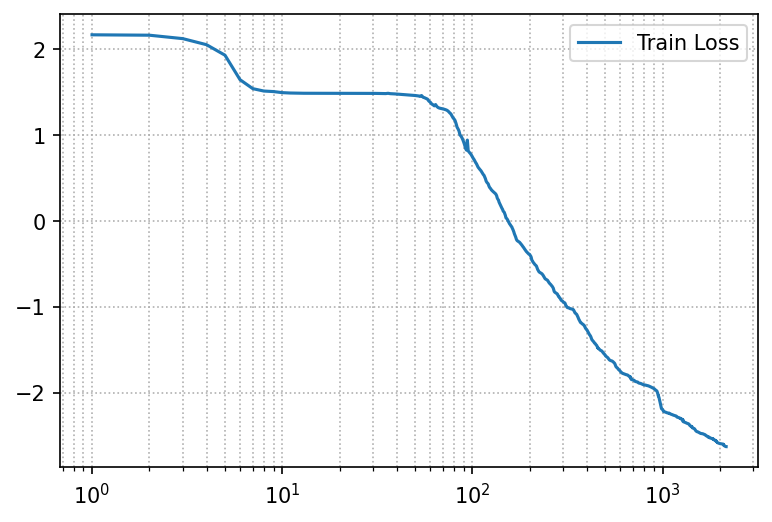

In [6]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

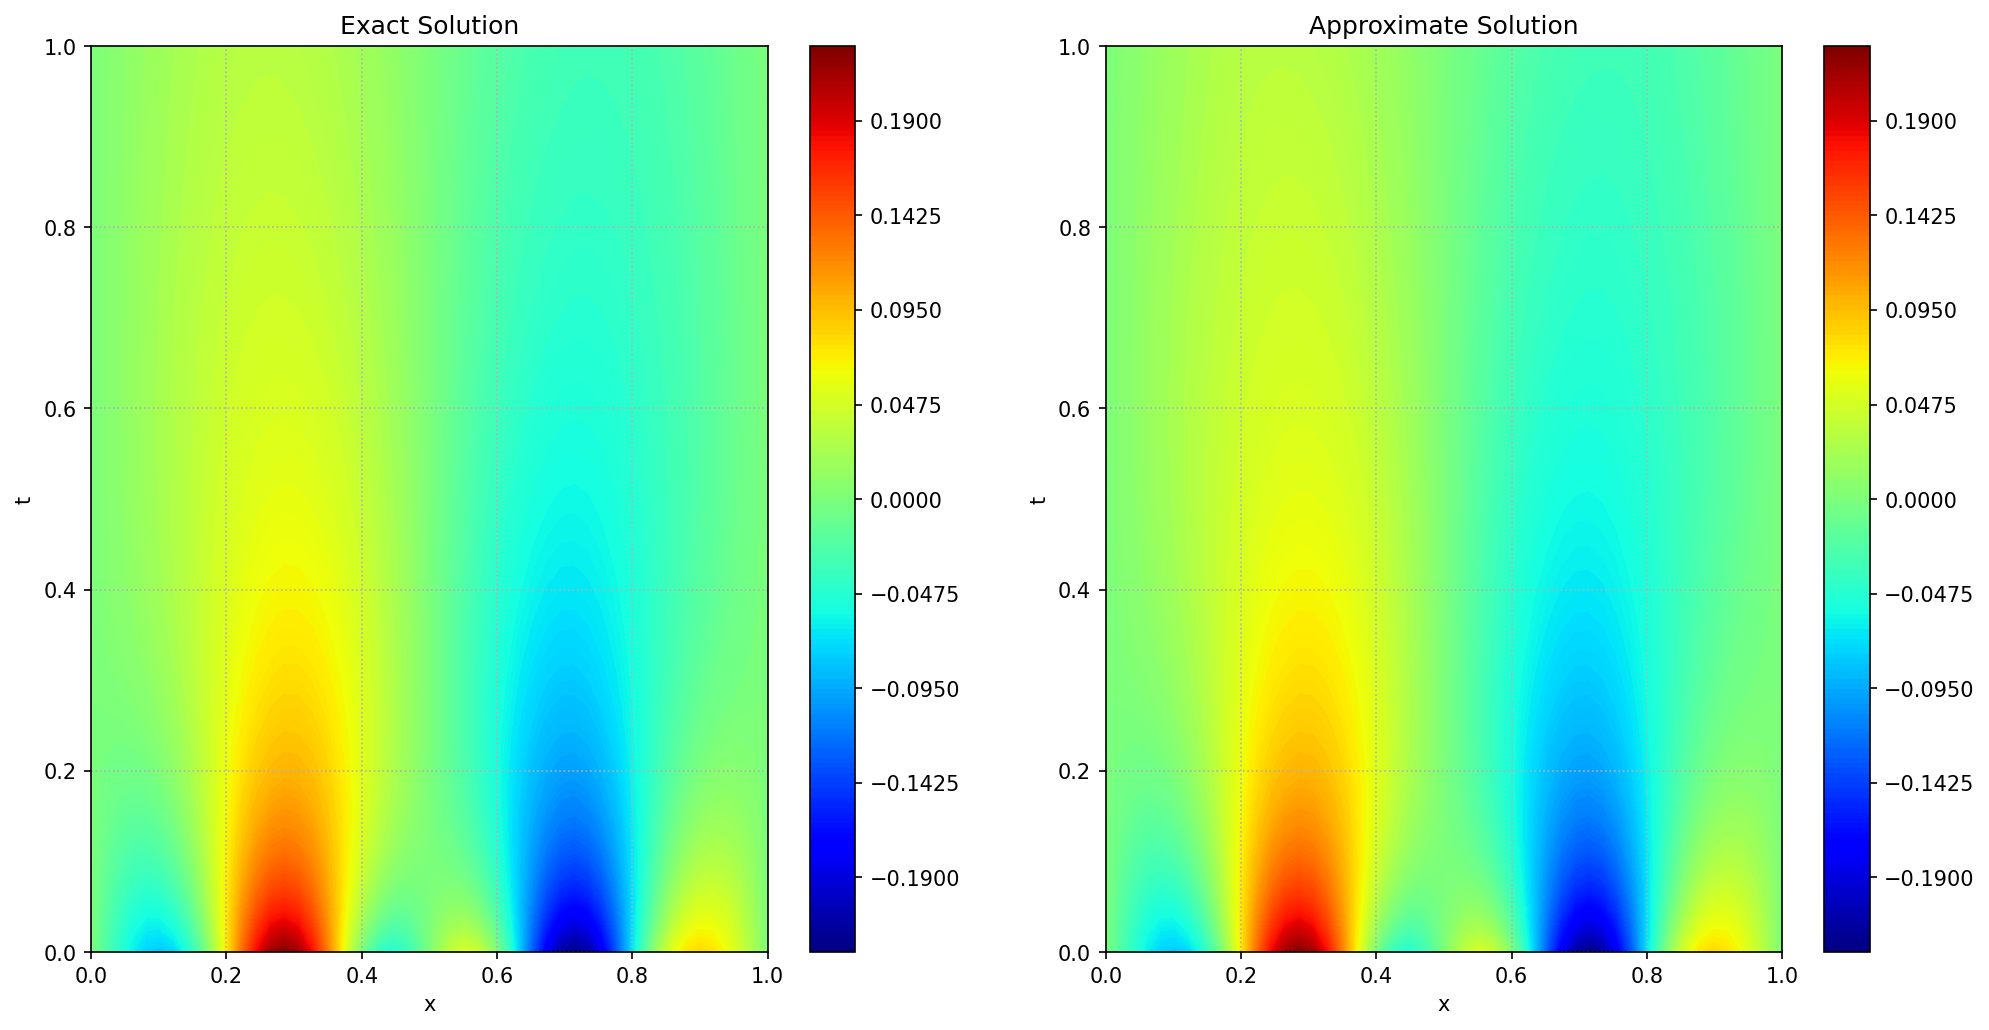

L2 Relative Error Norm:  0.6527846455574036 %


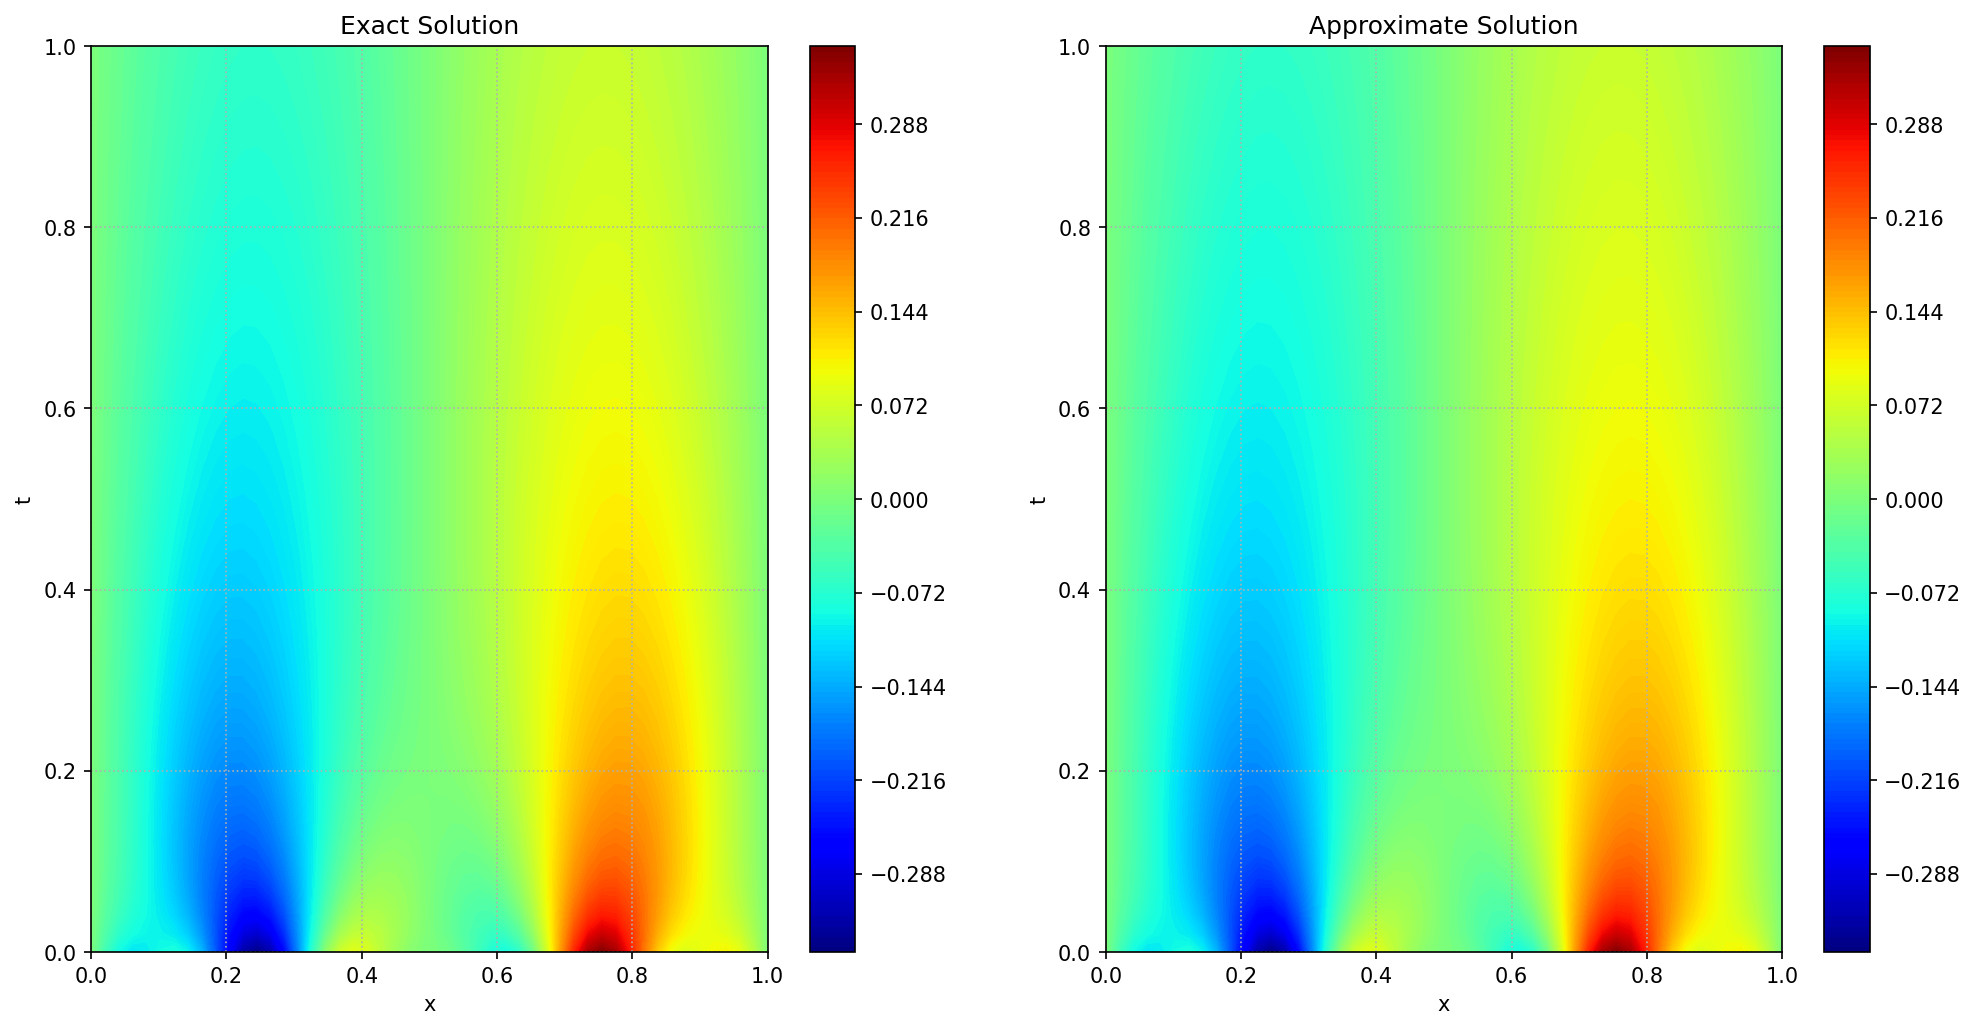

L2 Relative Error Norm:  0.5686869621276855 %


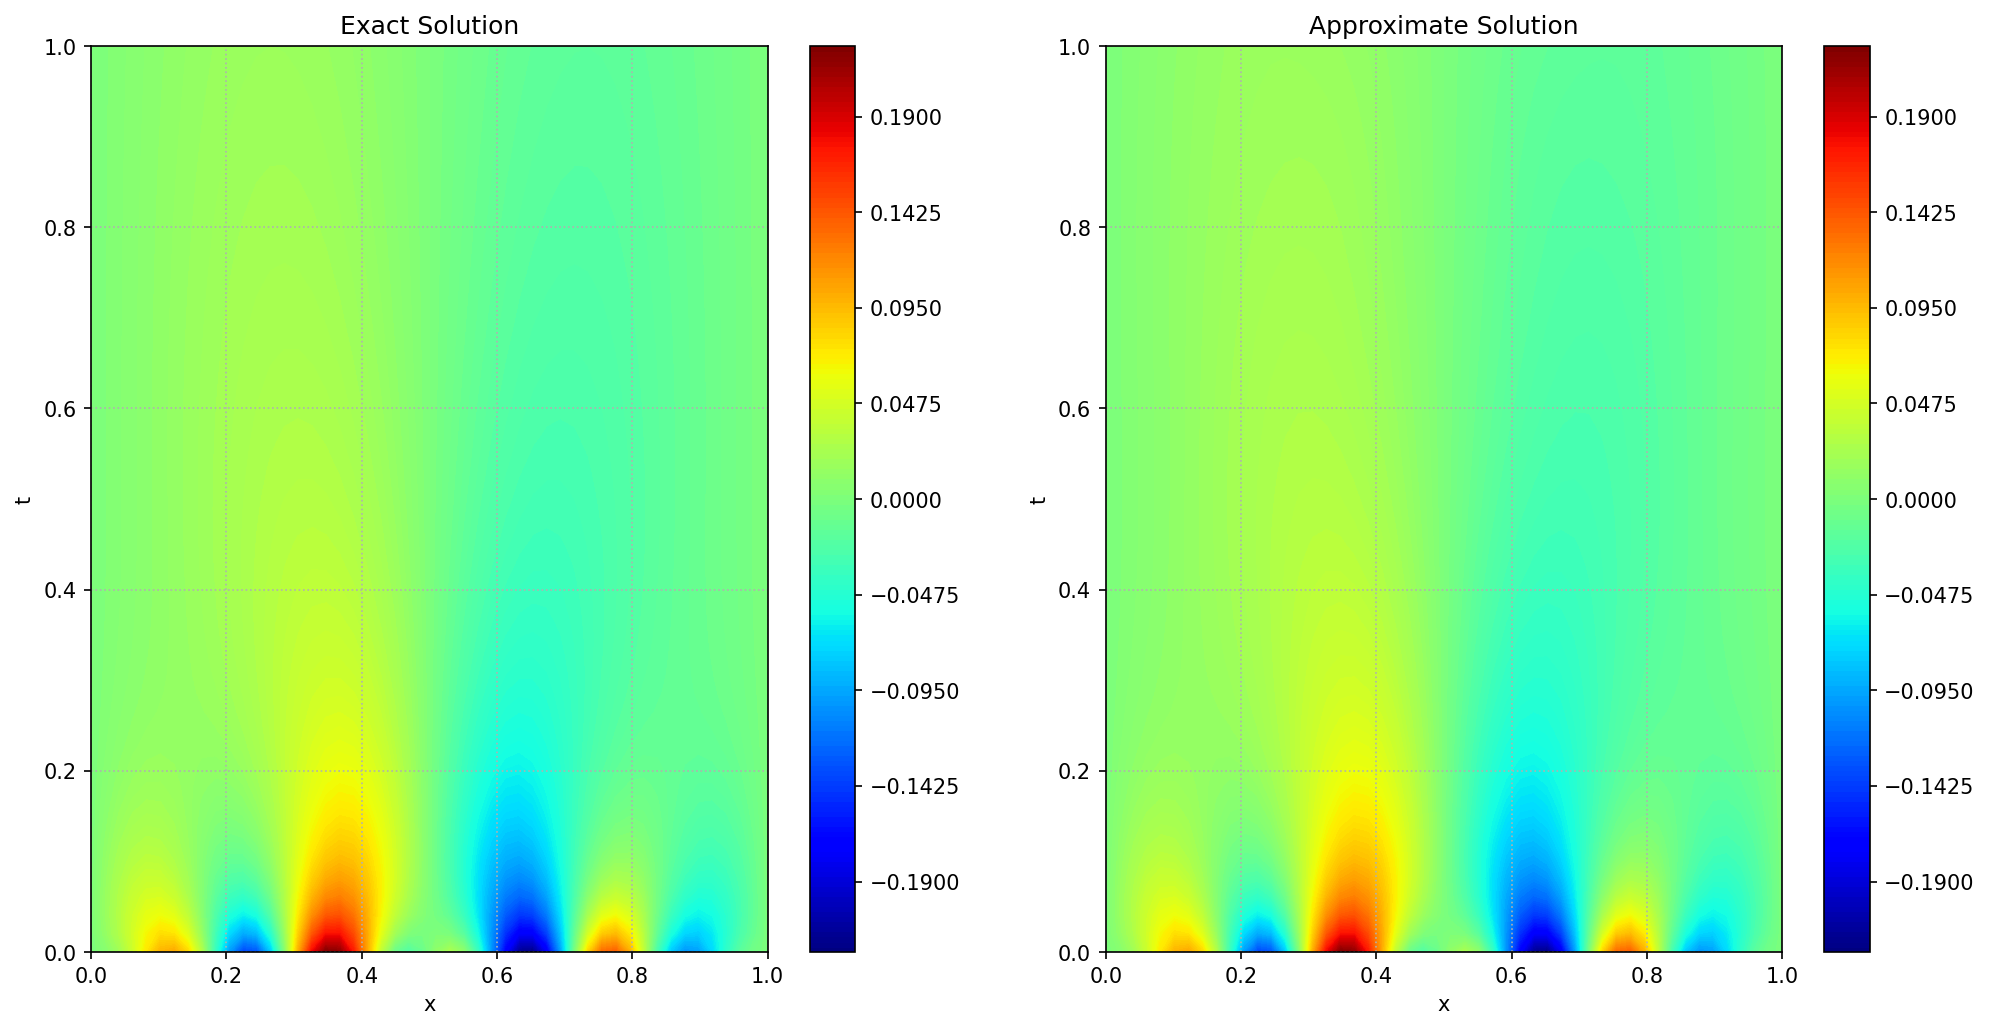

L2 Relative Error Norm:  0.7616089582443237 %


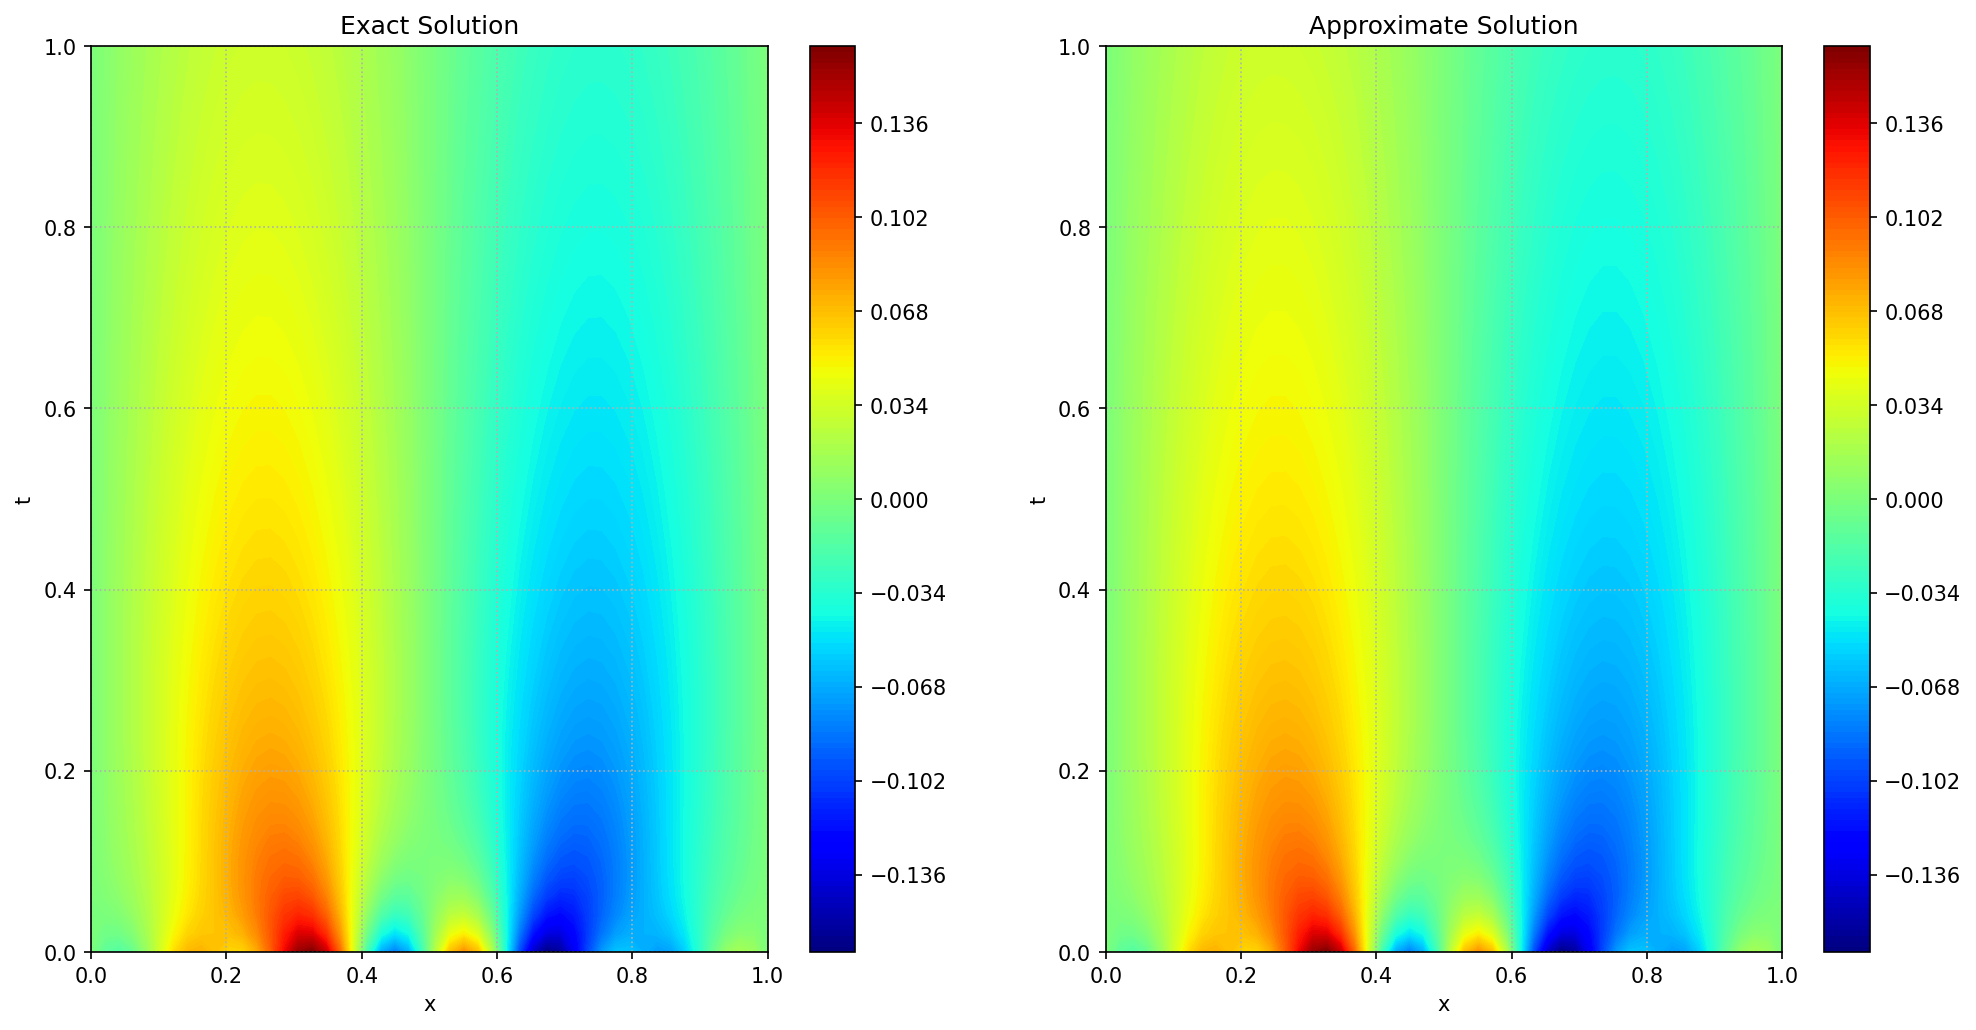

L2 Relative Error Norm:  0.5400094389915466 %


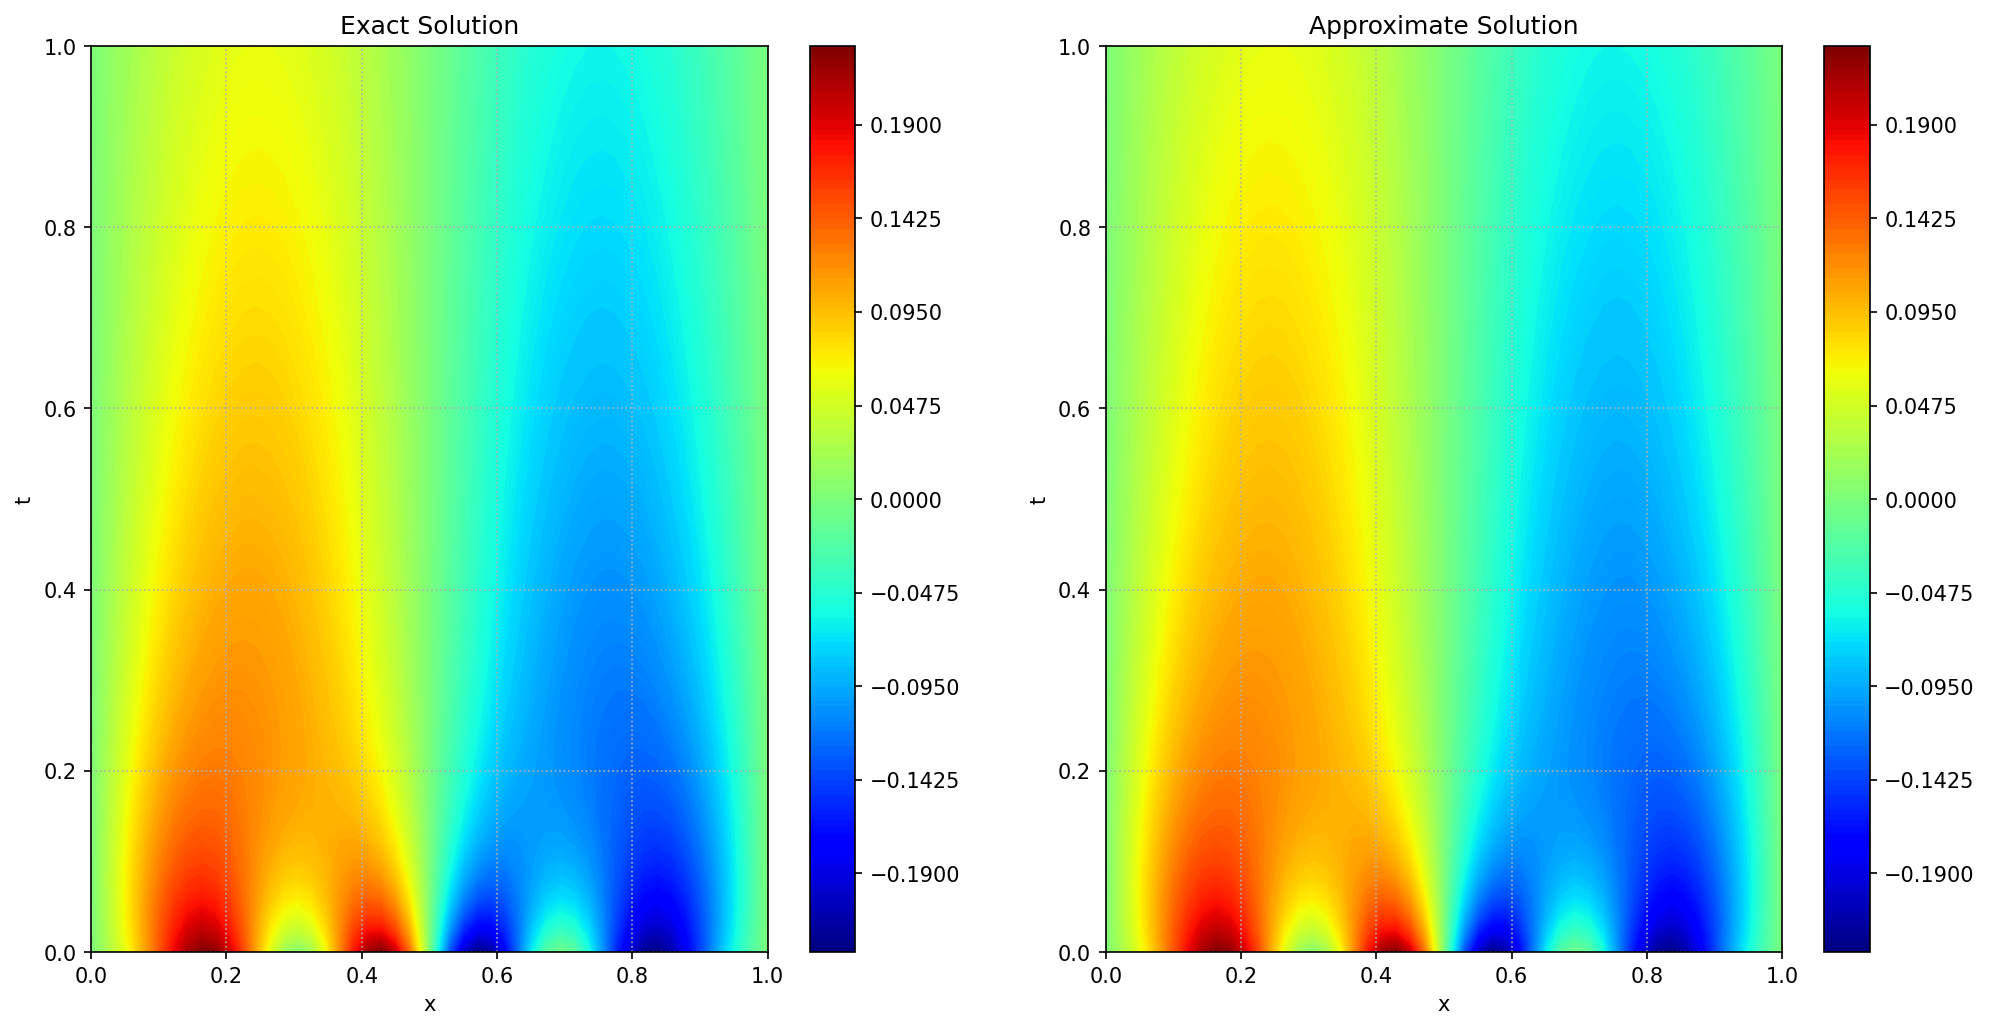

L2 Relative Error Norm:  0.5520735383033752 %


In [7]:
pinn.plotting()